In [7]:
# 1. Chargement des bibliothèques
# tidyverse contient ggplot2, dplyr, etc.
install.packages("tidyverse")
library(tidyverse)

# 2. Lecture du fichier
df <- read.csv("/content/sample_data/profiles_index.csv", stringsAsFactors = FALSE)

# 3. Aperçu des données
cat("Dimensions du dataset :", dim(df), "\n")
head(df)

# 4. Structure des données (Vérifier les types de colonnes)
str(df)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Dimensions du dataset : 30 7 


,login,name,company,location,total_stars,nb_repos_fetched,languages_list
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>
1,sindresorhus,Sindre Sorhus,,,457146,5,"JavaScript, TypeScript"
2,kamranahmedse,Kamran Ahmed,roadmap.sh,United Kingdom,426260,5,"JavaScript, Shell, TypeScript"
3,torvalds,Linus Torvalds,Linux Foundation,"Portland, OR",212950,5,"C, OpenSCAD"
4,getify,Kyle Simpson,Getify Solutions,"Austin, TX",203886,5,JavaScript
5,openai,OpenAI,,,174874,5,"Jupyter Notebook, Python, Rust, TypeScript"
6,ruanyf,Ruan YiFeng,,"Shanghai, China",129096,5,Makefile


'data.frame':	30 obs. of  7 variables:
 $ login           : chr  "sindresorhus" "kamranahmedse" "torvalds" "getify" ...
 $ name            : chr  "Sindre Sorhus" "Kamran Ahmed" "Linus Torvalds" "Kyle Simpson" ...
 $ company         : chr  "" "roadmap.sh" "Linux Foundation" "Getify Solutions" ...
 $ location        : chr  "" "United Kingdom" "Portland, OR" "Austin, TX" ...
 $ total_stars     : int  457146 426260 212950 203886 174874 129096 121230 119085 73999 62715 ...
 $ nb_repos_fetched: int  5 5 5 5 5 5 5 5 5 5 ...
 $ languages_list  : chr  "JavaScript, TypeScript" "JavaScript, Shell, TypeScript" "C, OpenSCAD" "JavaScript" ...


In [9]:
#2Nettoyage et transformation
# Remplacement des valeurs vides par "Unknown" dans Location et Company
df$location[df$location == "" | is.na(df$location)] <- "Unknown"
df$company[df$company == "" | is.na(df$company)] <- "Unknown"

# Création de variables "flags" pour les langages les plus populaires
df <- df %>%
  mutate(
    has_python = grepl("Python", languages_list),
    has_javascript = grepl("JavaScript", languages_list),
    has_typescript = grepl("TypeScript", languages_list)
  )

# Voir le résultat
head(df[, c("login", "total_stars", "has_python", "has_javascript")])

,login,total_stars,has_python,has_javascript
,<chr>,<int>,<lgl>,<lgl>
1,sindresorhus,457146,FALSE,TRUE
2,kamranahmedse,426260,FALSE,TRUE
3,torvalds,212950,FALSE,FALSE
4,getify,203886,FALSE,TRUE
5,openai,174874,TRUE,FALSE
6,ruanyf,129096,FALSE,FALSE


In [14]:
#3 Analyse Descriptive & Graphiques
# Stats descriptives pour les variables quantitatives
summary(df[, c("total_stars", "nb_repos_fetched")])

# Fréquences pour les variables qualitatives
table(df$Region)
table(df$JavaScript)

  total_stars     nb_repos_fetched
 Min.   :   606   Min.   :5       
 1st Qu.:  7846   1st Qu.:5       
 Median : 24728   Median :5       
 Mean   : 76980   Mean   :5       
 3rd Qu.:107814   3rd Qu.:5       
 Max.   :457146   Max.   :5       

< table of extent 0 >

< table of extent 0 >

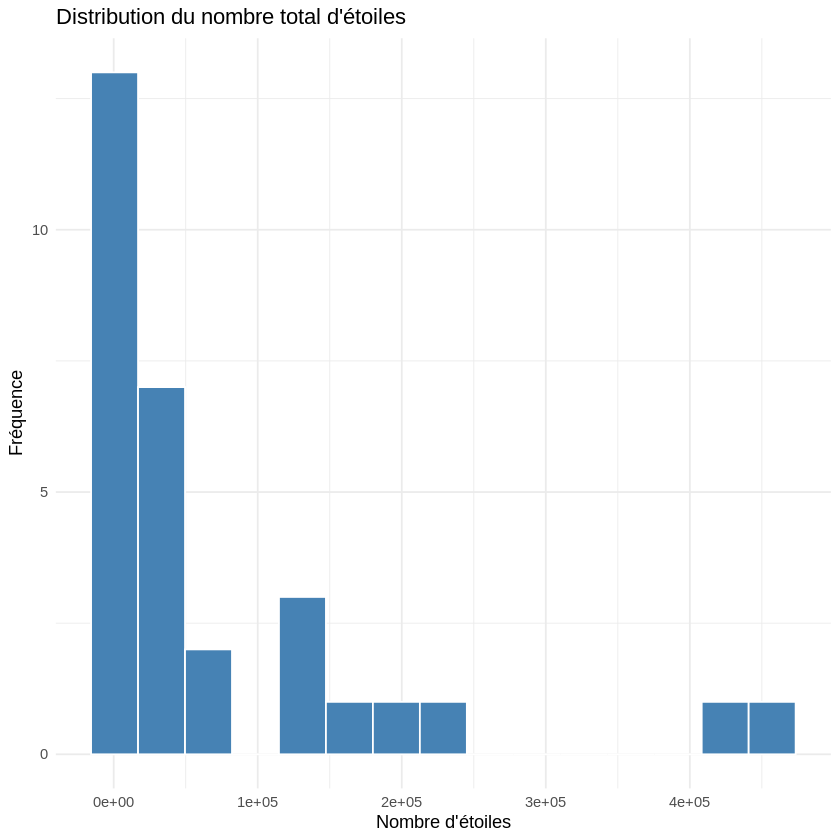

In [11]:
# Histogramme de la distribution des étoiles
ggplot(df, aes(x = total_stars)) +
  geom_histogram(fill = "steelblue", bins = 15, color = "white") +
  labs(title = "Distribution du nombre total d'étoiles",
       x = "Nombre d'étoiles", y = "Fréquence") +
  theme_minimal()

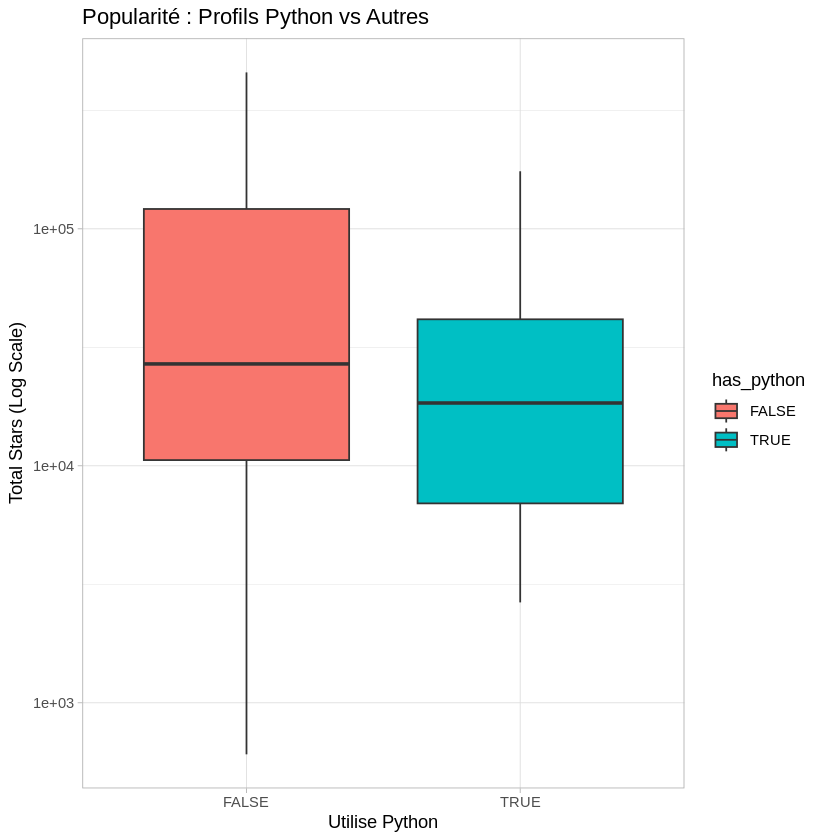

In [12]:
# Boxplot par langage (Ex: Python vs les autres)
ggplot(df, aes(x = has_python, y = total_stars, fill = has_python)) +
  geom_boxplot() +
  scale_y_log10() + # Utilisation d'une échelle log car les écarts sont énormes
  labs(title = "Popularité : Profils Python vs Autres",
       x = "Utilise Python", y = "Total Stars (Log Scale)") +
  theme_light()

In [13]:
#4 Analyse Statistique (Test de Wilcoxon)
# Question : Est-ce que les profils utilisant Python ont significativement
# plus d'étoiles que les autres ?
wilcox.test(total_stars ~ has_python, data = df)


	Wilcoxon rank sum exact test

data:  total_stars by has_python
W = 104, p-value = 0.6892
alternative hypothesis: true location shift is not equal to 0


Warning message in cor.test.default(df$num_languages, df$total_stars, method = "spearman"):
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula = 'y ~ x'


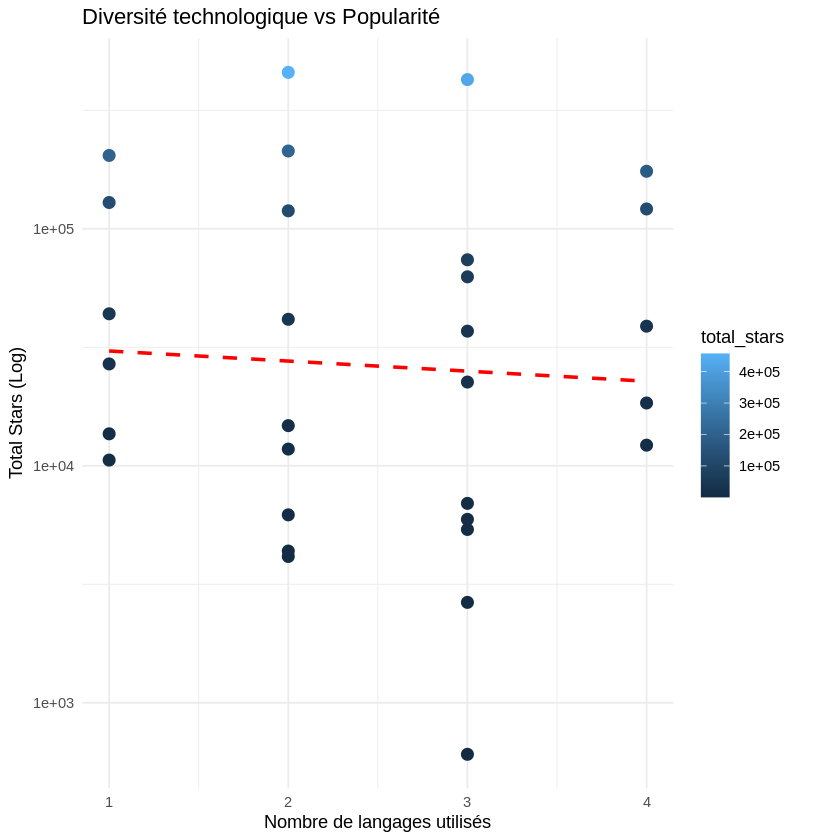

In [15]:
#5 Analyse de la Diversité Technologique (Corrélation)
# Calculer le nombre de langages par profil
df$num_languages <- str_count(df$languages_list, ",") + 1

# Test de corrélation de Spearman (adapté aux petites données non-normales)
cor_test <- cor.test(df$num_languages, df$total_stars, method = "spearman")

# Visualisation de la relation
ggplot(df, aes(x = num_languages, y = total_stars)) +
  geom_point(aes(color = total_stars), size = 3) +
  geom_smooth(method = "lm", se = FALSE, color = "red", linetype = "dashed") +
  scale_y_log10() +
  labs(title = "Diversité technologique vs Popularité",
       x = "Nombre de langages utilisés",
       y = "Total Stars (Log)") +
  theme_minimal()

In [18]:
#6 Analyse de la "Puissance" des Langages (Fréquence pondérée)
# Définir le seuil du top 25%
seuil_top <- quantile(df$total_stars, 0.75)
df$is_superstar <- df$total_stars >= seuil_top

# Comparaison des langages pour les superstars
lang_summary <- df %>%
  group_by(is_superstar) %>%
  summarise(
    Pct_Python = mean(has_python) * 100,
    Pct_JS = mean(has_javascript) * 100,
    Pct_TS = mean(has_typescript) * 100
  )

print("Pourcentage d'utilisation des langages chez les Superstars vs Autres :")
print(lang_summary)

[1] "Pourcentage d'utilisation des langages chez les Superstars vs Autres :"
# A tibble: 2 × 4
  is_superstar Pct_Python Pct_JS Pct_TS
  <lgl>             <dbl>  <dbl>  <dbl>
1 FALSE              31.8   59.1   40.9
2 TRUE               25     50     50  


In [19]:
#7 Détection des Valeurs Atypiques (Outliers)
# Identification des outliers avec la méthode IQR
Q1 <- quantile(df$total_stars, 0.25)
Q3 <- quantile(df$total_stars, 0.75)
IQR_val <- Q3 - Q1
borne_sup <- Q3 + 1.5 * IQR_val

outliers <- df[df$total_stars > borne_sup, ]
cat("Nombre de profils considérés comme des anomalies statistiques (Superstars) :", nrow(outliers), "\n")
print(outliers[, c("login", "total_stars")])

Nombre de profils considérés comme des anomalies statistiques (Superstars) : 2 
          login total_stars
1  sindresorhus      457146
2 kamranahmedse      426260


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: RColorBrewer



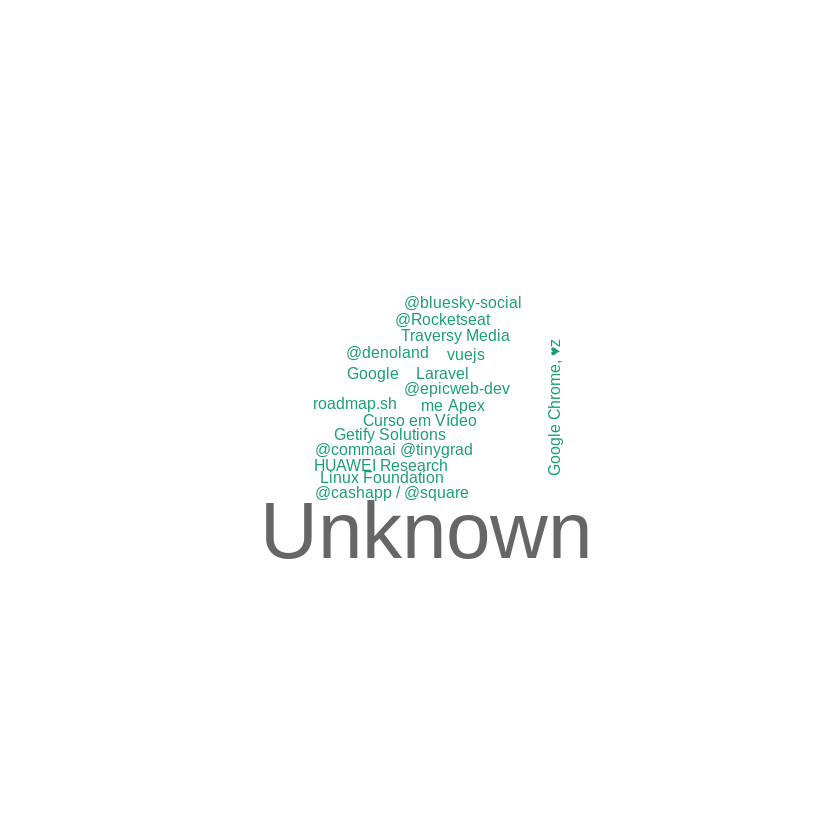

In [20]:
#8 Analyse de Texte : Nuage de mots des Entreprises (WordCloud)
install.packages("wordcloud")
library(wordcloud)

# Créer un tableau de fréquence des entreprises (en ignorant les "Indépendants")
comp_freq <- table(df$company[df$company != "Indépendant"])

wordcloud(names(comp_freq), as.numeric(comp_freq),
          min.freq = 1, colors = brewer.pal(8, "Dark2"),
          main = "Écosystème des Entreprises")